In [ ]:
!pip install langdetect

In [ ]:
!pip install pyLDAvis

In [62]:
# not necessary
# added to suppress warnings coming from pyLDAvis

import warnings
warnings.filterwarnings('ignore')

# plotting
import matplotlib.pyplot
%matplotlib inline

In [63]:
import langdetect  # language detection
import nltk  # natural language processing
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer
import numpy  # arrays and matrices
import pandas  # dataframes
import pyLDAvis  # plotting
import pyLDAvis.sklearn  # plotting
import regex  # regular expressions
import string
from unicodedata import normalize
import sklearn  # machine learning

import spacy
import spacy_spanish_lemmatizer

from html import unescape

from joblib import Parallel, delayed

In [88]:
# installing specific word dictionarys
# used for stopword removal and lemmatization

nltk.download("words")
nltk.download("wordnet")
nltk.download("stopwords")

nlp = spacy.load("es_core_news_sm")
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

include_stopwords = set(pandas.read_csv("stopwords.csv").data.tolist())
include_stopwords = set([i for i in include_stopwords if type(i) == str])
len(include_stopwords)

[nltk_data] Downloading package words to /home/alexander/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1182

In [65]:
path = 'agregado_vacantes_scraping_20210701.xlsx'
df = pandas.read_excel(path)
df.head()

,Cargo,Descripcion,Educacion requerida,Experiencia requerida (meses),Tipo de empleo,Empresa,Sector,Cantidad de aplicantes,Fecha de publicacion,Fecha de expiracion,Ciudad,Pais,Url vacante
0,Financial Controller,&lt;p&gt;¡Estás interesado en hacer parte de u...,bachelor degree,NaN,FULL_TIME,Adbid - Marketing Digital para E-commerce,Marketing y publicidad,147 solicitudes,2021-06-25T14:01:05.000Z,2021-07-25T14:01:04.000Z,Bogotá,CO,https://co.linkedin.com/jobs/view/financial-co...
1,Asistente de Gerencia RPO,DESCRIPCIÓN DEL PUESTO&lt;br&gt;&lt;br&gt;Dar ...,NaN,NaN,FULL_TIME,GRUPO STT,Contabilidad,194 solicitudes,2021-06-26T01:11:33.000Z,2021-07-26T01:11:33.000Z,Bogotá,CO,https://co.linkedin.com/jobs/view/asistente-de...
2,Regional Communication Manager LATAM,Regional Communication Manager LATAM&lt;br&gt;...,bachelor degree,120.0,FULL_TIME,ABB,Manufactura eléctrica/electrónica,94 solicitudes,2021-06-19T00:00:00.000Z,2021-07-23T07:29:47.000Z,Bogotá,CO,https://co.linkedin.com/jobs/view/regional-com...
3,Especialista Lean,&lt;strong&gt;Especialista Lean&lt;br&gt;&lt;/...,NaN,NaN,FULL_TIME,Michael Page,"Telecomunicaciones,Biotecnología,Servicios y t...",NaN,2021-05-31T23:16:51.000Z,2021-07-25T23:16:50.000Z,Bogotá,CO,https://co.linkedin.com/jobs/view/especialista...
4,Gerencia Comercial,&lt;strong&gt;Gerencia Comercial&lt;br&gt;&lt;...,bachelor degree,NaN,FULL_TIME,Michael Page,"Ingeniería industrial o mecánica,Manufactura e...",NaN,2021-05-31T23:16:49.000Z,2021-07-25T23:16:49.000Z,Colombia,CO,https://co.linkedin.com/jobs/view/gerencia-com...


In [66]:
df = df[["Cargo", "Descripcion", "Fecha de publicacion", "Fecha de expiracion"]]
df.columns

Index(['Cargo', 'Descripcion', 'Fecha de publicacion', 'Fecha de expiracion'], dtype='object')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Cargo                 678 non-null    object
 1   Descripcion           678 non-null    object
 2   Fecha de publicacion  678 non-null    object
 3   Fecha de expiracion   678 non-null    object
dtypes: object(4)
memory usage: 21.3+ KB


In [68]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 656
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Cargo                 428 non-null    object
 1   Descripcion           428 non-null    object
 2   Fecha de publicacion  428 non-null    object
 3   Fecha de expiracion   428 non-null    object
dtypes: object(4)
memory usage: 16.7+ KB


In [69]:
# define quick look function for data frame

def dataframe_quick_look(df, nrows):
    print("SHAPE:\n{shape}\n".format(shape=df.shape))
    print("COLUMN NAMES:\n{names}\n".format(names=df.columns))
    print("HEAD:\n{head}\n".format(head=df.head(nrows)))
    
dataframe_quick_look(df, nrows=2)

SHAPE:
(428, 4)

COLUMN NAMES:
Index(['Cargo', 'Descripcion', 'Fecha de publicacion', 'Fecha de expiracion'], dtype='object')

HEAD:
                       Cargo  \
0      Financial Controller    
1  Asistente de Gerencia RPO   

                                         Descripcion  \
0  &lt;p&gt;¡Estás interesado en hacer parte de u...   
1  DESCRIPCIÓN DEL PUESTO&lt;br&gt;&lt;br&gt;Dar ...   

       Fecha de publicacion       Fecha de expiracion  
0  2021-06-25T14:01:05.000Z  2021-07-25T14:01:04.000Z  
1  2021-06-26T01:11:33.000Z  2021-07-26T01:11:33.000Z  



In [70]:
# data set came with prespecified topics
# print the topics out with counts

print("TOPICS:\n{topics}\n".format(topics=df["Cargo"].value_counts()))

TOPICS:
Auxiliar administrativo                 11
Recepcionista hotel                      7
Auxiliar servicio al cliente             6
Jefe logística                           5
Auxiliar archivo                         4
                                        ..
Jefe mercadeo y ventas                   1
Dependiente judicial                     1
Analista de laboratorio - Bogotá         1
Country Marketing Manager - Colombia     1
Gerente general hotel                    1
Name: Cargo, Length: 341, dtype: int64



In [72]:
# view final data that will be carried forward

raw = df['Descripcion'].tolist()
print("HEADLINES:\n{lines}\n".format(lines=raw[:1]))
print("LENGTH:\n{length}\n".format(length=len(raw)))

HEADLINES:
['&lt;p&gt;¡Estás interesado en hacer parte de una de las mejores agencias de Marketing Digital!&lt;/p&gt;&lt;p&gt;&lt;br&gt;&lt;/p&gt;&lt;p&gt;Si eres profesional en alguna de las siguientes carreras: Administración de Empresas, Ingeniería Industrial, Economía, Finanzas, con conocimientos financieros y de planeación financiera, experiencia superior a 2 años, ser muy analítico(a) y con liderazgo, puedes postularte o enviarnos tu hoja de vida a Johanna.rodriguez@adbid.com.co para revisar tu perfil y de ajustarse nos pondremos en contacto.&lt;/p&gt;&lt;p&gt;&lt;br&gt;&lt;/p&gt;&lt;ul&gt;&lt;li&gt;¡Si cuentas con estas características postúlate aquí! te ofrecemos excelente plan de beneficios, crecimiento a nivel personal y profesional, salario a convenir.&lt;/li&gt;&lt;/ul&gt;']

LENGTH:
428



In [73]:
def clean_html(text):
    cleantext = unescape(text)
    cleanr = regex.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = regex.sub(cleanr, ' ', cleantext)
    return cleantext

# check language of headline
# filter to english only

def do_language_identifying(txt):
    try: the_language = langdetect.detect(txt)
    except: the_language = 'none'
    return the_language

# define function to perform lemmatization

def do_lemmatizing(txt):
    text_lemma = nlp(txt)
    tokens = [word.lemma_ for word in text_lemma]
    return tokens
    #out = WordNetLemmatizer().lemmatize(wrd)
    #return (wrd if out is None else out)

In [18]:
# define function to cleaning tweet data

def do_text_cleaning(txt):
    
    txt = clean_html(txt)
    
    txt = txt.lower()
       
    # identify language of tweet
    # return null if language not english
    lg = do_language_identifying(txt)
    if lg != 'es':
        return None
    
    # lemmatizing
    #out = [do_lemmatizing(i) for i in out]
    txt = " ".join(do_lemmatizing(txt))
    
    # Remove text in square brackets, remove punctuation and remove words containing numbers.
    txt = txt.replace("ñ", "nh")
    txt = regex.sub(r"\[.*?¿\]\%", " ", txt)
    txt = regex.sub(r"https://", "", txt)
    txt = regex.sub(r"www.", "", txt)
    txt = regex.sub(r"[‘’“”…«»]", "", txt)
    txt = regex.sub(r'["\[\]\{\}]', "", txt)
    txt = regex.sub(r"_", " ", txt)
    txt = regex.sub(r"[%s]" % regex.escape(string.punctuation), " ", txt)
    txt = regex.sub(r"\w*\d\w*", "", txt)
    txt = regex.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize("NFD", txt), 0, regex.I
    )
    txt = regex.sub(r"\n", " ", txt)
    txt = regex.sub(r"&lt;/?.*?&gt;", " &lt;&gt; ", txt)

    # Eliminar caracteres que se repitan más de dos veces seguidas
    pattern = regex.compile(r"(.)\1{2,}")
    txt = pattern.sub(r"\1\1", txt)

    
    # split the string on whitespace
    out = txt.split(' ')
   
    
    # identify screen names
    # replace with SCREENNAME
    out = ['SCREENNAME' if i.startswith('@') else i for i in out]
    
    # identify urls
    # replace with URL
    out = [
        'URL' if bool(regex.search('http[s]?://', i)) 
        else i for i in out
    ]
    
    # remove all punctuation
    out = [regex.sub('[^\\w\\s]|\n', '', i) for i in out]
    
    # make all non-keywords lowercase
    keys = ['SCREENNAME', 'URL']
    out = [i.lower() if i not in keys else i for i in out]
    
    # remove keywords
    out = [i for i in out if i not in keys]
    
    # remove stopwords
    list_stop_words = set(nltk.corpus.stopwords.words('spanish'))
    list_stop_words |= include_stopwords
    list_stop_words = [regex.sub('[^\\w\\s]', '', i) for i in list_stop_words]
    
    out = [i for i in out if i not in list_stop_words]
    
    # keep words 4 or more characters long
    out = [i for i in out if len(i) >= 4]
    
    return out

In [89]:
# apply cleaning function to every vacancy

#clean = list(map(do_text_cleaning, raw))
clean = Parallel(n_jobs=8)(delayed(do_text_cleaning)(txt) for txt in raw)

In [90]:
# remove none types

clean = list(filter(None.__ne__, clean))
print("HEADLINES:\n{lines}\n".format(lines=clean[:1]))
print("LENGTH:\n{length}\n".format(length=len(clean)))

HEADLINES:
[['mejores', 'agencias', 'marketing', 'digital', 'profesional', 'alguno', 'carrera', 'administracion', 'empresa', 'ingenieria', 'industrial', 'economia', 'finanzas', 'financiero', 'planeacion', 'financiero', 'experiencia', 'superior', 'analitico', 'liderazgo', 'puedes', 'postularte', 'enviarnos', 'johanna', 'rodriguez', 'adbid', 'revisar', 'ajustarse', 'poner', 'contacto', 'caracteristica', 'aqui', 'plan', 'personal', 'profesional']]

LENGTH:
381



In [91]:
# turn tokens back into strings
# concatenate using whitespaces

clean_sentences = [" ".join(i) for i in clean]
clean_sentences[0:1]

['mejores agencias marketing digital profesional alguno carrera administracion empresa ingenieria industrial economia finanzas financiero planeacion financiero experiencia superior analitico liderazgo puedes postularte enviarnos johanna rodriguez adbid revisar ajustarse poner contacto caracteristica aqui plan personal profesional']

### Count Vectorizer

In [156]:
# define some global variables

number_words = 10
number_docs = 10
number_features = 1000

In [157]:
# execute bag of words model
# use raw term counts for lda 
# as it is a probabilistic graphical model

vectorizer1 = sklearn.feature_extraction.text.CountVectorizer(
    analyzer="word",
    max_df=0.5, 
    min_df=0.08, 
    max_features=number_features
)
clean_vec1 = vectorizer1.fit_transform(clean_sentences)
print(clean_vec1[0])

feature_names_vec1 = vectorizer1.get_feature_names()

  (0, 44)	2
  (0, 6)	1
  (0, 0)	1
  (0, 16)	1
  (0, 27)	1
  (0, 25)	1
  (0, 20)	2
  (0, 32)	1
  (0, 39)	1
  (0, 38)	1


In [158]:
len(feature_names_vec1), feature_names_vec1

(62,
 ['administracion',
  'administrativo',
  'analisis',
  'area',
  'atencion',
  'calidad',
  'carrera',
  'cliente',
  'comercial',
  'comerciales',
  'comunicacion',
  'cumplimiento',
  'dato',
  'decision',
  'desarrollar',
  'desarrollo',
  'empresa',
  'equipo',
  'estrategia',
  'estrategico',
  'financiero',
  'gerencia',
  'gestion',
  'gestionar',
  'herramienta',
  'industrial',
  'informacion',
  'ingenieria',
  'ingles',
  'intermedio',
  'lider',
  'liderar',
  'liderazgo',
  'logistica',
  'mercado',
  'negociacion',
  'negocio',
  'organizacion',
  'personal',
  'plan',
  'posicion',
  'presupuesto',
  'proceso',
  'producto',
  'profesional',
  'programa',
  'proyecto',
  'reportar',
  'requerimiento',
  'requisito',
  'responsabilidad',
  'responsable',
  'sector',
  'seguimiento',
  'servicio',
  'sistema',
  'tecnico',
  'tecnologia',
  'tecnologo',
  'trabajar',
  'trabajo',
  'venta'])

### Select Number of Topics

In [159]:
# define function to calculate perplexity for LDA model trained on ntopics

def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [], 
        "Perplexity Score": []
    }
    
    for t in ntopics:
        lda = sklearn.decomposition.LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0,
            n_jobs=-1
        )
        lda.fit(data)
        
        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))
        
    output_df = pandas.DataFrame(output_dict)
    
    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]
        
    return (output_df, output_num_topics)

In [160]:
# find perplexity scores for several different numbers of topics
# takes several minutes

df_perplexity, optimal_num_topics = perplexity_by_ntopic(
    clean_vec1, 
    ntopics=[1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15]
)
print(df_perplexity)

    Number Of Topics  Perplexity Score
0                  1         54.262824
1                  2         54.321884
2                  3         56.727947
3                  4         56.238959
4                  6         58.753736
5                  8         58.358532
6                 10         58.796775
7                 11         60.079356
8                 12         60.791300
9                 13         60.069231
10                14         62.773837
11                15         62.838918


<AxesSubplot:xlabel='Number Of Topics'>

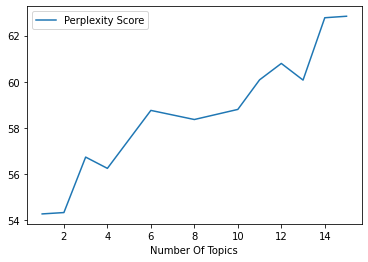

In [161]:
df_perplexity.plot.line("Number Of Topics", "Perplexity Score")

In [162]:
optimal_num_topics = 4

In [163]:
# define and fit LDA model

lda = sklearn.decomposition.LatentDirichletAllocation(
    n_components=optimal_num_topics,
    learning_method="online",
    random_state=0,
    n_jobs=-1
)
lda.fit(clean_vec1)

LatentDirichletAllocation(learning_method='online', n_components=4, n_jobs=-1,
                          random_state=0)

In [164]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
print(lda_transform.shape)
print(lda_transform)

(381, 4)
[[0.02158782 0.02020311 0.93797726 0.02023181]
 [0.2549209  0.00287564 0.20718066 0.5350228 ]
 [0.00895944 0.17714543 0.80493175 0.00896338]
 ...
 [0.47661465 0.20112798 0.02013575 0.30212162]
 [0.86752922 0.04297637 0.04322414 0.04627027]
 [0.83992358 0.05200131 0.05658274 0.05149237]]


In [165]:
# output matrix
# w: words to topics

lda_components = lda.components_
print(lda_components.shape)
print(lda_components)

(4, 62)
[[ 40.84444952  30.13264487  30.80647304  41.18106467  19.7876456
    9.09214659  26.33597252 158.9001457   88.8108122   53.44949813
   48.18287272  21.56555577   5.98629163  19.77070618  45.85023119
   41.50636674  99.26377411 148.98205453  66.90632812  19.43886263
   23.55676689  40.67449111  22.55861267  12.44185726  10.45029906
   24.79699276   4.74846062  29.00155483  36.38137925  19.37407953
   24.0401175   49.53419136  44.60166829   1.79660497  44.43870523
   22.78540447  68.42973488  20.02106712  36.49208119  25.77537366
   18.26667125  31.57320731  13.7272505   60.98475723  68.16426613
    4.34070881   2.23401707   6.56117477  29.22862725   9.98192199
   25.61320267  18.0373993   62.13680698  13.38412843  55.04859755
    4.11500676   3.69998651  13.36604526   4.93705385  53.25211921
   97.36979217  81.97625465]
 [  1.27902013  18.61549546   7.56394822  26.8322781   11.74441949
    3.03810238  13.56743522  34.59922814  12.26635398   5.82563565
    2.74018081   4.1287872

In [166]:
# define function to reformat output matrices into easily readable tables

def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, numpy.newaxis]
    # topic to document matrix
    H = mod.transform(vec)
    
    W_dict = {}
    H_dict = {}
    
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)
        
        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in W_indices
        ]
        W_dict[topic] = W_names_values
        
        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j]) 
            for j in H_indices
        ]
        H_dict[topic] = H_names_values
        
    W_df = pandas.DataFrame(
        W_dict, 
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pandas.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )
        
    return (W_df, H_df)

In [167]:
# run function

W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

In [168]:
# word-topic table
print(W_df)

                      Topic0                 Topic1                    Topic2  \
Word0      (0.0704, cliente)      (0.112, proyecto)     (0.0863, profesional)   
Word1        (0.066, equipo)      (0.1008, empresa)         (0.0649, proceso)   
Word2       (0.044, empresa)     (0.0842, reportar)      (0.0608, financiero)   
Word3      (0.0431, trabajo)       (0.074, tecnico)            (0.0538, area)   
Word4    (0.0394, comercial)  (0.0704, informacion)         (0.0537, empresa)   
Word5        (0.0363, venta)  (0.0472, profesional)  (0.0482, administracion)   
Word6      (0.0303, negocio)   (0.0449, ingenieria)      (0.0429, ingenieria)   
Word7  (0.0302, profesional)      (0.0442, cliente)      (0.0427, industrial)   
Word8   (0.0296, estrategia)     (0.0417, gerencia)         (0.0399, carrera)   
Word9       (0.0275, sector)         (0.0343, area)  (0.0336, administrativo)   

                      Topic3  
Word0      (0.0902, gestion)  
Word1      (0.0797, proceso)  
Word2      (0.0

In [169]:
# document-topic table
print(H_df)

                                                 Topic0  \
Doc0  (0.9874, &lt;strong&gt;&lt;u&gt;Job Descriptio...   
Doc1  (0.9862, &lt;strong&gt;Gerencia Comercial&lt;b...   
Doc2  (0.9855, &lt;strong&gt;Reporta a&lt;/strong&gt...   
Doc3  (0.9841, &lt;strong&gt;Sobre la empresa&lt;br&...   
Doc4  (0.9796, Manejo de Excel y word ideal conocimi...   
Doc5  (0.9787, puntualidad respeto honestidad buen t...   
Doc6  (0.9782, &lt;strong&gt;Coordinación Administra...   
Doc7  (0.978, &lt;p&gt;The Andean Products team is p...   
Doc8  (0.9732, &lt;strong&gt;Project Manager Oil &am...   
Doc9  (0.9725, Dominio del inglés B1KPIS Eficiencia ...   

                                                 Topic1  \
Doc0  (0.9793, &lt;strong&gt;Dirección de Negocios S...   
Doc1  (0.9667, &lt;p&gt;Nuestra pandilla está expand...   
Doc2  (0.9629, &lt;strong&gt;¡TE QUEREMOS EN NUESTRO...   
Doc3  (0.9103, Empresa requiere Asesor Servicio al C...   
Doc4  (0.9095, Persona honesta responsable con orien...

### Visualizing LDA

In [170]:
# iterative visualization
# featuring pca biplot and histogram
lda_plot = pyLDAvis.sklearn.prepare(lda, clean_vec1, vectorizer1, R=10)
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_plot)

In [137]:
# define functiont to fit and plot t-SNE model

def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = numpy.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]
    
    # fit tsne model
    # x-d -> 2-d, x = number of topics
    tsne = sklearn.manifold.TSNE(
        n_components=2, 
        verbose=0, 
        random_state=0, 
        angle=0.5, 
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)
    
    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())
    
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = numpy.unique(
        numpy.array(most_prob_topic), 
        return_counts=True
    )

    print("COUNTS:\n{}\n".format(numpy.asarray((unique, counts)).T))
    
    # make plot
    matplotlib.pyplot.figure(figsize=(10,6))
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        matplotlib.pyplot.scatter(
            x=tsne_fit[indices, 0], 
            y=tsne_fit[indices, 1], 
            s=0.5, 
            c=color_list[i], 
            label='Topic' + str(i),
            alpha=1
        )
    
    
    matplotlib.pyplot.xlabel('x-tsne')
    matplotlib.pyplot.ylabel('y-tsne')
    matplotlib.pyplot.legend(markerscale=10)

LENGTH:
381

COUNTS:
[[  0  91]
 [  1 157]
 [  2 133]]



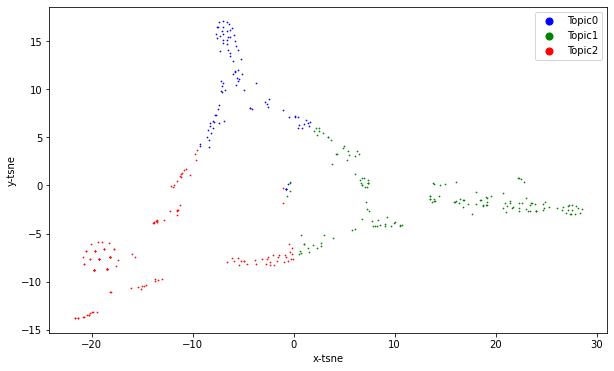

In [138]:
plot_tsne(data=lda_transform, threshold=0)

In [139]:
# define and fit nmf model

nmf = sklearn.decomposition.NMF(
    n_components=optimal_num_topics,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=0.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)

NMF(alpha=0.1, init='nndsvda', l1_ratio=0.5, n_components=3, random_state=0,
    solver='mu')

In [140]:
# run function to produce nice output tables

W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

In [141]:
# word-topic table
print(W_df)

                         Topic0                    Topic1  \
Word0         (0.0847, empresa)         (0.1869, proceso)   
Word1     (0.0778, profesional)        (0.1083, proyecto)   
Word2          (0.0645, equipo)         (0.0848, gestion)   
Word3       (0.047, ingenieria)        (0.0648, servicio)   
Word4      (0.0451, financiero)         (0.0617, sistema)   
Word5       (0.0404, comercial)         (0.0413, trabajo)   
Word6        (0.0397, gerencia)      (0.0365, desarrollo)   
Word7  (0.0372, administracion)        (0.0314, personal)   
Word8             (0.037, area)     (0.0292, informacion)   
Word9           (0.035, sector)  (0.0272, administracion)   

                         Topic2  
Word0         (0.2807, cliente)  
Word1        (0.1354, servicio)  
Word2          (0.0507, equipo)  
Word3         (0.0357, trabajo)  
Word4         (0.0349, negocio)  
Word5         (0.0346, empresa)  
Word6        (0.0322, personal)  
Word7          (0.0286, sector)  
Word8  (0.0283, admini

In [142]:
# document-topic table
print(H_df)

                                                 Topic0  \
Doc0  (1.0109, &lt;strong&gt;Acerca de Autolab&lt;br...   
Doc1  (0.9238, &lt;strong&gt;Reporta a&lt;/strong&gt...   
Doc2  (0.8932, En el espacio asignado de Habilidades...   
Doc3  (0.8786, &lt;strong&gt;Gerencia Comercial&lt;b...   
Doc4  (0.8742, &lt;p&gt;Estudiante Universitario que...   
Doc5  (0.8402, &lt;strong&gt;&lt;u&gt;Job Descriptio...   
Doc6  (0.8099, Manejo de Excel y word ideal conocimi...   
Doc7  (0.7861, &lt;strong&gt;Gerente Comercial&lt;br...   
Doc8  (0.7591, Laboratorio Farmacéutico ubicado en e...   
Doc9  (0.7004, &lt;strong&gt;Gerencia de Canales&lt;...   

                                                 Topic1  \
Doc0  (2.6914, &lt;strong&gt;Gerencia Mercadeo&lt;br...   
Doc1  (1.6642, &lt;p&gt;¡Buscamos talento como tú! ¡...   
Doc2  (1.3903, &lt;strong&gt;CEO&lt;br&gt;&lt;/stron...   
Doc3  (1.3504, &lt;strong&gt;Coordinación de Manufac...   
Doc4  (1.3236, DESCRIPCIÓN DEL PUESTO&lt;br&gt;&lt;b...

In [143]:
# output raw document-topic matrix for t-SNE plot
nmf_transform = nmf.transform(clean_vec1)
print(nmf_transform.shape)
print(nmf_transform)

(381, 3)
[[2.95450643e-01 4.42258118e-03 3.04448291e-13]
 [7.48264611e-02 1.32356923e+00 1.86865074e+00]
 [3.55090954e-01 7.72343479e-01 3.30465707e-04]
 ...
 [1.24195258e-01 7.62750937e-03 1.80208803e-01]
 [3.58257215e-02 3.78392636e-06 1.03762226e-02]
 [9.08688510e-02 9.96817498e-03 3.10065364e-03]]


LENGTH:
381

COUNTS:
[[  0 218]
 [  1  93]
 [  2  70]]



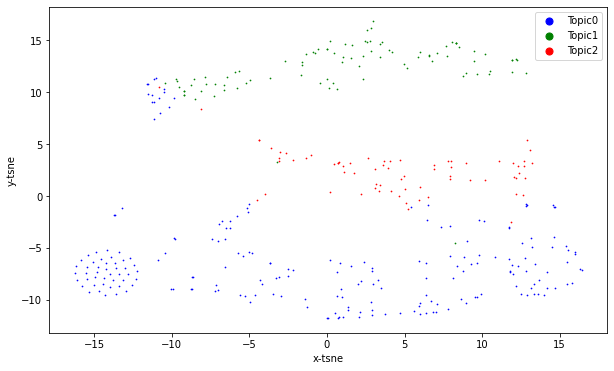

In [144]:
# run function to produce t-SNE plot
plot_tsne(data=nmf_transform, threshold=0)